In [76]:
import os
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F

In [370]:
import matplotlib.pyplot as plt
%matplotlib inline

# Reading the data

In [13]:
# Downloading the file
filepath = '../data/input.txt'
if not os.path.exists(filepath):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(filepath, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

In [19]:
# Reading the file
with open(filepath) as f:
    raw_text = f.read()

print(raw_text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [32]:

# ordered list of all characters in the corpus
vocab = sorted(list(set(raw_text)))
vocab_size = len(vocab)
print(f'vocab_size: {vocab_size}')

# dictionaries to convert chars to ints, and viceversa
itos = {i:v for i,v in enumerate(vocab)}
stoi = {v:i for i,v in enumerate(vocab)}

# functions to tokenize sequences of arbitrary length
encode = lambda x : [stoi[s] for s in x]
decode = lambda x : ''.join([itos[i] for i in x])

hello_encoded = encode('hello!')
hello_decoded = decode(hello_encoded)
print(f'encode.    hello   => {hello_encoded}')
print(f'decode.    {hello_encoded}   => {hello_decoded}')

vocab_size: 65
encode.    hello   => [46, 43, 50, 50, 53, 2]
decode.    [46, 43, 50, 50, 53, 2]   => hello!


In [34]:
# Tokenizing the text an creating a numerical tensor
token_text = torch.tensor(encode(raw_text))
token_text.shape

torch.Size([1115394])

In [35]:
# Splitting data in train, val
train_size = int(0.9 * len(token_text))
data_train = token_text[:train_size]
data_val = token_text[train_size:]
print(data_train.shape, data_val.shape)

torch.Size([1003854]) torch.Size([111540])


In [72]:
# Preparing training batches

torch.manual_seed(1337)

batch_size = 4   # the number of sample processed in the same batch
block_size = 8   # the length of the sequence of character used by the model to predict the next character

def get_batch(data, batch_size, block_size):

    # generating the start index of  batch_size independent samples
    idx = torch.randint(len(data)-block_size, (batch_size,))

    # extracting the xi, each having block_size elements
    x = torch.stack([data[i:i+block_size] for i in idx])

    # extracting the yi, the next characters
    y = torch.stack([data[i+1:i+1+block_size] for i in idx]) 
    return x, y

x_train, y_train = get_batch(data_train, batch_size, block_size)

In [73]:
print(x_train.shape)
print(x_train)
print()
print(y_train.shape)
print(y_train)

torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])

torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])


# Creating models

## Bigram model


In [204]:
# Predicts next character using only the previous character

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()

        # A table mapping the index of each character, to the logits distribution of the next character
        # The element E[i,j] represent the logit associated to next character being j, when the current 
        # character is i
        self.E = nn.Embedding(vocab_size, vocab_size)

    def forward(self, X, y=None):

        # extracting the logits of the next character, for each character in the input
        # The shape of the input is (batch_size, block_size)
        # The shape of the output is (batch_size, block_size, vocab_size)
        logits = self.E(X)

        # computing loss, only when a target y is provided
        if y is not None:
            # reshaping logits, and target to match the expected shapes of the cross_entropy function
            batch_size, block_size, vocab_size = logits.shape
            logits = logits.view((batch_size*block_size, vocab_size))
            y = y.view(batch_size*block_size)
            
            # computing the loss
            loss = F.cross_entropy(logits, y)
        else:
            loss = None

        return logits, loss

    def generate(self, X, max_length=100):

        for i in range(max_length):
            # performing a forward pass
            logits, loss = self.forward(X)
    
            # condsidering only the last character of each sequence
            logits = logits[:, -1, :]
    
            # computing probs, from the logits
            probs = logits.softmax(dim=-1)
    
            # sampling from the probability distributions
            new_element = torch.multinomial(probs, 1)
    
            # attaching the new elements to the context
            X = torch.concat((X, new_element), axis=1)

        # Decoding the generated sequences
        res = [decode(X[i].tolist()) for i in range(X.shape[0]) ]

        return res

In [205]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(x_train, y_train)
logits.shape, loss

(torch.Size([32, 65]), tensor(4.7027, grad_fn=<NllLossBackward0>))

In [211]:
# Generating sequence from UNTRAINED model

# creating initial context
context = torch.zeros((1, 1)).int()

# generating sequence of arbitrary length 
res = m.generate(context, max_length=100)

print(res[0])


.Y:pb,xY;?
zBblo GCGv;
K:sC?KugUDt
ED;Dtj;Dc$ab!avNsl,pAfdEqOfbzmSo!&iTjxFoCIyHSmy;zwU3p3b?:EMIy PAW


In [212]:
# Training a model with Adam Optimizer
optimizer = torch.optim.Adam(m.parameters(), lr=10**(-3))

for i in range(10000):

    # generating a random batch
    X_b, y_b = get_batch(data_train, batch_size, block_size)

    # forward pass
    logits, loss = m(X_b, y_b)

    # bacward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(loss.item())

4.6096601486206055
3.907146453857422
3.3213071823120117
2.8333771228790283
2.9970436096191406
2.904151439666748
2.7995710372924805
2.4972057342529297
2.693941354751587
2.48555588722229


In [214]:
# Generating sequence from TRAINED model

# creating initial context
context = torch.zeros((1, 1)).int()

# generating sequence of arbitrary length 
res = m.generate(context, max_length=500)

print(res[0])


ABd hatratdir on lir o tre:
E:
O:
TEY;
Duraso.ped arerd.
He de, I lande, ompe'sepOM3rehe IG me ake it heard zibas way nd nd hireagmbeexj?
Lorerdithofo:
A:
HME:
vpees; PW-pe Lbe warothe m s crve y;
Nucoun ld,
YAufotoouson Bup'do-hor haved isonderis byou:
These l oll d d st a
NGS:D tllatofare d:
M3BAt h cen'd ourgor rs, f he chor wharome terelaime be s ISous mec?d; cwis o te: Q.
dl toul, anoubesus kifrnthes,
A r heinoun, h cis oo therer intootlinod ce whooue mons
Bis,

The celikexpas gls l o merrs


## Transformer model

In [273]:
# We want to create a transformation matrix that for each token, collects information for all 
# the previous tokens in the sequence.
# Let's assume that emb_size = 2, and block_size=3
# If we have a matrix 
#     
# W = [[ 1, 0, 0]
#      [ 1, 1, 0]
#      [ 1, 1, 1]]
#
# and sample X_i representing a sequence of tokens of size emb size
#
# X_i =[[ 3, 5]       # token at time 0
#       [ 8, 10]      # token at time 1
#       [ 6, 2]]      # token at time 2
#
# then if we perform a matrix multiplication between W and  and X_i
# we obtain 
#
# Z_i = [[ 3, 5]      # token at time 0
#        [11, 15]     # token at time 1
#        [17, 17]]    # token at time 2
# 
# where the token at time j is obtained by summing al the tokens until time j included.

W = torch.tril(torch.ones((3,3)))
print(f'W = {W}')

X_i = torch.tensor([[ 3, 5],
                    [ 8, 10],
                    [ 6, 2]] ).float()
print()
print(f'X_i = {X_i}')

Z_i = W @ X_i
print()
print(f'Z_i = {Z_i}')

W = tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

X_i = tensor([[ 3.,  5.],
        [ 8., 10.],
        [ 6.,  2.]])

Z_i = tensor([[ 3.,  5.],
        [11., 15.],
        [17., 17.]])


In [274]:
# Since we want merge into each time step the knowledge from the previous time steps
# a simple mean would be more appropriate than a sum
W = torch.tril(torch.ones((3,3))) 
W /= W.sum(axis=1, keepdims=True)
print(f'W = {W}')

X_i = torch.tensor([[ 3, 5],
                    [ 8, 10],
                    [ 6, 2]] ).float()
print()
print(f'X_i = {X_i}')

Z_i = W @ X_i
print()
print(f'Z_i = {Z_i}')

W = tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])

X_i = tensor([[ 3.,  5.],
        [ 8., 10.],
        [ 6.,  2.]])

Z_i = tensor([[3.0000, 5.0000],
        [5.5000, 7.5000],
        [5.6667, 5.6667]])


In [277]:
# In practice we want to be able to learn the matrix W by backpropagation, and not set them manually.
# If we start from a triangular matrix, and keep updating it through backpropagation, there is no
# guarantee that zeros will stay 0.
# One trick to keep the triangular shape of the matrix is to replace the zeros with -inf:
#   - no amount of change will change the -inf
#   - when, eventually, applying a softmax to the result the -inf values will become zeros

W = torch.tril(torch.ones((3,3))) 
W /= W.sum(axis=1, keepdims=True)
W[W == 0.] = -torch.inf
print(f'W = {W}')

X_i = torch.tensor([[ 3, 5],
                    [ 8, 10],
                    [ 6, 2]] ).float()
print()
print(f'X_i = {X_i}')

Z_i = W.softmax(axis=1) @ X_i
print()
print(f'Z_i = {Z_i}')

W = tensor([[1.0000,   -inf,   -inf],
        [0.5000, 0.5000,   -inf],
        [0.3333, 0.3333, 0.3333]])

X_i = tensor([[ 3.,  5.],
        [ 8., 10.],
        [ 6.,  2.]])

Z_i = tensor([[3.0000, 5.0000],
        [5.5000, 7.5000],
        [5.6667, 5.6667]])


Q.shape = torch.Size([40, 10])
K.shape = torch.Size([40, 10])
W.shape = torch.Size([40, 40])


'\na = torch.randn(50,100)\nprint(a.std(axis= 1).mean())\nb = torch.randn(50,100)\nprint(b.std(axis= 1).mean())\nab = (a @ b.T) \nprint(ab.std(axis= 1).mean())\nab_norm = ab * 100**-0.5\nprint(ab_norm.std(axis= 1).mean())\n'

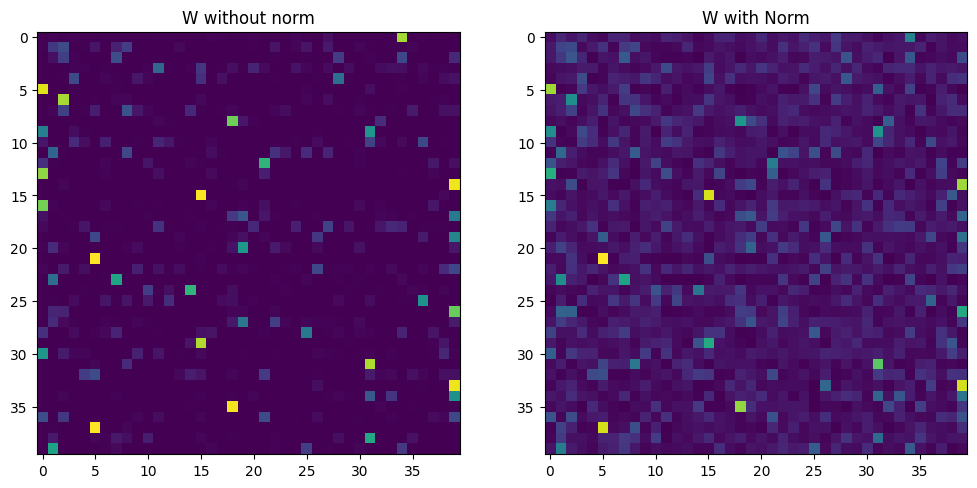

In [393]:
# In the transformer architecture the matrix W of size (context_size, context_size) is not a raw parameter,
# but rather the result of some computations.
# The matrix X_e, of size (context_size, emb_size) where each row is a token in the space of size emb_size
# is first projected  into a smaller space of size head_size. 
# This projection is a actually repeated three times to obtain matrices with different meanings:
#   - The rows of the matrix K represent the information with which a token should be indexed
#   - The rows of the matrix Q represent the information that a token is interested in
#   - The rows of the matrix V are projections of X_e that contains the info to be shareds
#
# When multiplying  matrix K of size (context_size, emb_size) and the transposse of Q
# of size (context_size, emb_size) we obtain a matrix of size (context_size, context_size)
# where the element at position (i,j) represents the amount of information that needs to be
# shared from token at position j to the token at position i.
# This matrix has the same shape and function as the matrix W discussed before.
# Adding a softmax operation we can obtain a matrix where each row is a probability distribution,
# and the element (i,j) gives us exactly the fraction of the token j that we want to transfer 
# to the token i.
#
# The last steps to perform is multilplying the self-attention matrix W by the input to operate the transfer 
# of information among tokens.
# This operation is performed in a space of size head_size, using the projected matrix V, 
# instead of the original matrix X_e.
#
#  The result of the attention mechanism is thus:
#   Z = softmax(Q x K.T) x V
#
#  The only detail remaining is the the normalization of the (Q x K.T) matrix to insure that the rows have unit variance.
#  If it's not the case (Q x K.T) might contain values that have large magnitude, and after applying the softmax
#  operation, the result will tend be a one-hot vector where only 1 or a few elemnts are different from zero,
#  while the otheres will be virtually zero.
#  Under this situation the attention mechanism will be greatly compromised, as a token will receive information
#  only from a handful of tokens in the context.
# Ex

context_size = 40
head_size = 10

# Generating Q and k
Q = torch.randn(context_size, head_size)
print(f'Q.shape = {Q.shape}')
K = torch.randn(context_size, head_size)
print(f'K.shape = {K.shape}')


# Multiplying the Q and K to obtain the W matrix
W = Q @ K.T
print(f'W.shape = {W.shape}')

# Normalizing with sqrt(head_size)
W_norm  = W / head_size**0.5

# Compting softmax of bot original and normalized
W_soft = W.softmax(axis=1)
W_norm_soft = W_norm.softmax(axis=1)

# Comparing the weight distribution with, and without normalization
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax0.set_title('W without norm')
ax0.imshow(W_soft)
ax1.set_title('W with Norm')
ax1.imshow(W_norm_soft)


'''
a = torch.randn(50,100)
print(a.std(axis= 1).mean())
b = torch.randn(50,100)
print(b.std(axis= 1).mean())
ab = (a @ b.T) 
print(ab.std(axis= 1).mean())
ab_norm = ab * 100**-0.5
print(ab_norm.std(axis= 1).mean())
'''

In [436]:
# Predicts next character using all previous characters

class TransformerLanguageModel(nn.Module):

    def __init__(self, vocab_size, emb_size, block_size, head_size):
        super().__init__()

        self.block_size = block_size

        # A table mapping the index of each character, to an embedding vector X_e_0 of size emb_size
        self.E = nn.Embedding(vocab_size, emb_size)

        # # A table mapping the position of each character, to an embedding vector X_e_0 of size emb_size
        self.P = nn.Embedding(block_size, emb_size)

        # The transformations mapping X_e to a space of size head_size.
        # X_e is a "private" representation of a token.
        # From this vector we can project different  representations
        #   - K => represents the information that X_e could provide (KEY)
        #   - Q => represents the information that X_e might require (QUERY)
        #   - V => represents the information that X_e will actually provide (VALUE)
        self.W_k = nn.Linear(emb_size, head_size)
        self.W_q = nn.Linear(emb_size, head_size)
        self.W_v = nn.Linear(emb_size, head_size)
        
        # Output layer to produce the logits
        self.output_layer = nn.Linear(head_size, vocab_size)
        

    def forward(self, X, y=None):

        # Transforming the input indices to embedding vectors
        # The shape of the input is (batch_size, block_size)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e_0 = self.E(X)

        # Transforming the input indices to embedding vectors
        # The shape of the input is (block_size)
        # The shape of the output is (block_size, emb_size)
        X_pos = torch.arange(0, self.block_size)  # creating matrix with positions: [0, 1, ...]
        X_e_1 = self.P(X_pos)   

        # Adding together the embedding vectors
        # The shape of X_e_0 is (batch_size, block_size, emb_size)
        # The shape of X_e_1 is  (block_size, emb_size)
        # (Broadcasting will make the operation possible)
        # The shape of the output is (batch_size, block_size, emb_size)
        X_e = X_e_0 + X_e_1


        # Projecting the embedding vector X_e to obtain K, Q, V in the space of size head_size
        K = self.W_k(X_e)
        Q = self.W_q(X_e)
        V = self.W_v(X_e)

        # Matrix providing the attention mechanism
        # - It is obtained comparing one by one, the rows of K with the rows of Q
        # - The scalar product between the i-th row of K and j-th row of Q represents
        #   the 'affinity' between the token at position i and the token at position j
        # - We divide by sqrt(emb_size) to ensure that the rows have unit variance
        # - We mask it with a triangular matrix to avoid contamination from tokens 
        #   in the future
        W  = torch.tril(Q @ K.transpose(1,2))  # we transpose only the last 2 dims. 1st dim is batch 
        W /= W.sum(axis=1, keepdims=True)
        W[W == 0.] = -torch.inf

        # Applying attention mechanism to get info from previous steps in the block
        # The mechanism is applied to the projection V
        X_a = W.softmax(axis=1) @ V
        
        # Extracting the logits of the next character, for each character in the input
        # The shape of the input is (batch_size, block_size, emb_size)
        # The shape of the output is (batch_size, block_size, vocab_size)
        logits = self.output_layer(X_a)

        # computing loss, only when a target y is provided
        if y is not None:
            # reshaping logits, and target to match the expected shapes of the cross_entropy function
            batch_size, block_size, vocab_size = logits.shape
            logits = logits.view((batch_size*block_size, vocab_size))
            y = y.view(batch_size*block_size)
            
            # computing the loss
            loss = F.cross_entropy(logits, y)
        else:
            loss = None

        return logits, loss

    def generate(self, X, max_length=100):

        # initilizing the result
        res = X.clone()

        for i in range(max_length):
            # performing a forward pass
            logits, loss = self.forward(X)
    
            # condsidering only the last character of each sequence
            logits = logits[:, -1, :]
    
            # computing probs, from the logits
            probs = logits.softmax(dim=-1)
    
            # sampling from the probability distributions
            new_element = torch.multinomial(probs, 1)
    
            # attaching the new elements to the context
            # and excluding the oldest element
            X = torch.concat((X[:, 1:], new_element), axis=1)

            # Storing the generated element
            res = torch.concat((res, new_element), axis=1)

        # Decoding the generated sequences
        res = [decode(res[i].tolist()) for i in range(res.shape[0]) ]

        return res

In [437]:
emb_size = 32
head_size = 16
m1 = TransformerLanguageModel(vocab_size, emb_size, block_size, head_size)
logits, loss = m1(x_train, y_train)
logits.shape, loss

(torch.Size([32, 65]), tensor(4.2521, grad_fn=<NllLossBackward0>))

In [441]:
# Training a model with Adam Optimizer
optimizer1 = torch.optim.Adam(m1.parameters(), lr=10**(-3))

steps = 100000
for i in range(steps):

    # generating a random batch
    X_b, y_b = get_batch(data_train, batch_size, block_size)

    # forward pass
    logits, loss = m1(X_b, y_b)

    # bacward pass
    optimizer1.zero_grad(set_to_none=True)
    loss.backward()
    optimizer1.step()

    # printing at 10% intervals
    if i % int(steps / 10) == 0:
        print(loss.item())

3.0635299682617188
3.199181318283081
3.0119805335998535
2.7662734985351562
2.8942482471466064
2.9732120037078857
2.321126937866211
2.5919036865234375
2.54081392288208
2.6982009410858154


In [442]:
# Generating sequence from TRAINED model

# creating initial context
context = torch.zeros((1, block_size)).int()

# generating sequence of arbitrary length 
res = m1.generate(context, max_length=300)

print(res[0])









LALDBUCE:
TSextotur.

QUESENO:
WAMNIUS:
OLANUT:
HAs!
F RIORI:
Y:
B
Frot athe ize emat anpry ourscofuthe ancer fello me mbeigclane.
To hend atind me way thewine'ss, t hislis, ont hetes psatithe imens:

Fretre me hom evine dextewe anghat eringe cemer inche my of, wero wacthe orfer mor omy thatis, me w
